# Illustrating Observed and Intrinsic Object Properties:
# SDSS "Galaxy" Sizes


* In a catalog, each galaxy's measurements come with "error bars" providing information about how *uncertain* we should be about each property of each galaxy.

* This means that the distribution of "observed" galaxy properties (as reported in the catalog) is not the same as the underlying or "intrinsic" distribution.

* Let's look at the distribution of *observed sizes* in the SDSS photometric object catalog.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import SDSS
import pandas as pd
import matplotlib
%matplotlib inline

In [4]:
galaxies = "SELECT top 1000 \
petroR50_i AS size, \
petroR50Err_i AS err \
FROM PhotoObjAll \
WHERE \
(type = '3' AND petroR50Err_i > 0)"
print galaxies

SELECT top 1000 petroR50_i AS size, petroR50Err_i AS err FROM PhotoObjAll WHERE (type = '3' AND petroR50Err_i > 0)


In [5]:
# Download data. This can take a while...
data = SDSS.select(galaxies)
data

,size,err
0,3.183596,0.025126
1,3.065464,0.011983
2,20.184450,12.358810
3,3.140940,0.019812
4,2.944434,0.005674
5,8.316065,5.105838
6,0.896665,0.285496
7,0.744543,0.260797
8,0.908179,0.248295
9,1.143575,0.081928


## The Distribution of Observed SDSS "Galaxy" Sizes

Let's look at a histogram of galaxy sizes, for 1000 objects classified as "galaxies".

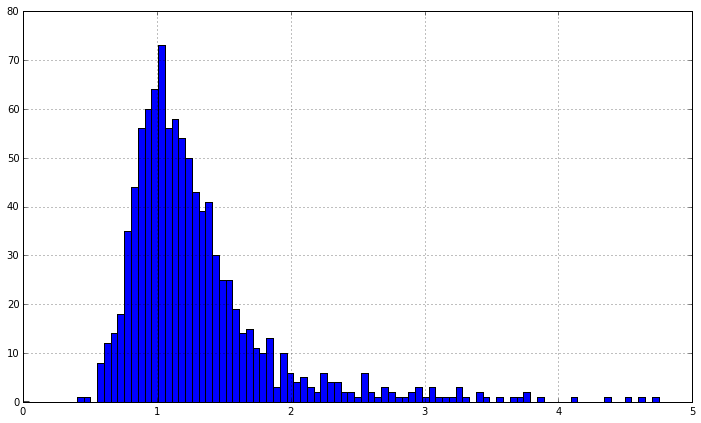

In [6]:
data['size'].hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7))

Things to notice:

* No small objects (why not?)
* A "tail" to large size
* Some very large sizes that look a little odd



Are these large galaxies *actually* large, or have they just been measured that way?
Let's look at the reported uncertainties on these sizes:

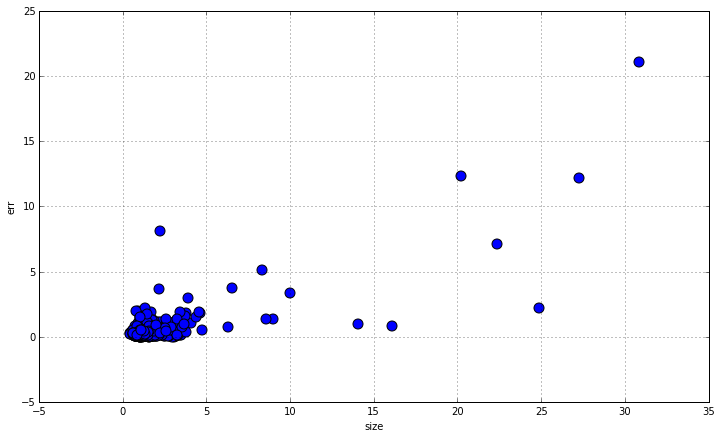

In [7]:
data.plot(kind='scatter', x='size', y='err',s=100,figsize=(12,7));

## Generating Mock Data

Let's look at how distributions like this one can come about, by making a **generative model** for this dataset.

First, let's imagine a set of perfectly measured galaxies. They won't all have the same size, because the Universe isn't like that. Let's suppose the logarithm of their *intrinsic sizes* are drawn from a Gaussian distribution of width $S$ and mean $\mu$. 

To model one mock galaxy, we *draw a sample from this distribution*. To model the whole dataset, we draw 1000 samples.

In [8]:
def generate_galaxies(mu=np.log10(1.5),S=0.3,N=1000):
    return pd.DataFrame({'size' : 10.0**(mu + S*np.random.randn(N))})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109f65110>]], dtype=object)

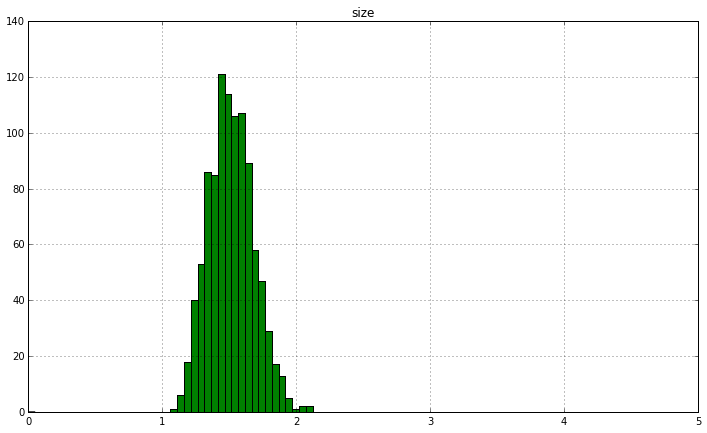

In [9]:
mu = np.log10(1.5)
S = 0.05
intrinsic = generate_galaxies(mu=mu,S=S,N=1000)

intrinsic.hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7),color='green')

Now let's add some observational uncertainty. We can model this by drawing random Gaussian offsets $\epsilon$ and add one to each intrinsic size.

In [10]:
def make_noise(sigma=0.3,N=1000):
    return pd.DataFrame({'size' : sigma*np.random.randn(N)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ce2dc90>]], dtype=object)

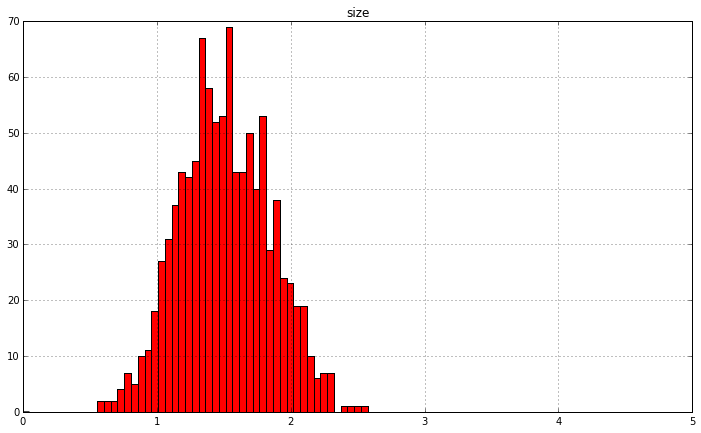

In [20]:
sigma = 0.3
errors = make_noise(sigma=sigma,N=1000)

observed = intrinsic + errors

observed.hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7),color='red')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d95b8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10dbc3b50>]], dtype=object)

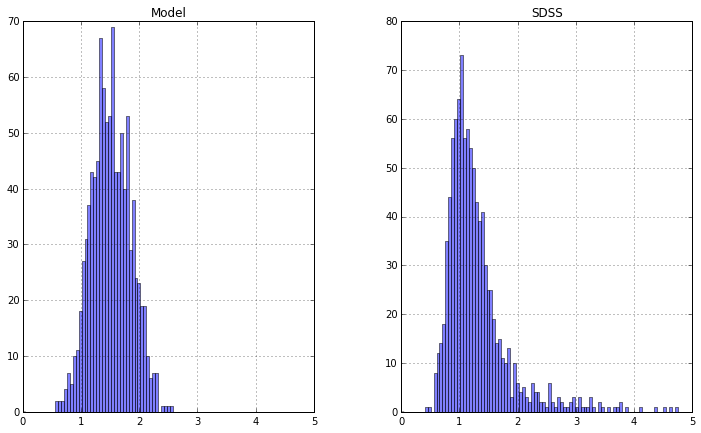

In [21]:
both = pd.DataFrame({'SDSS': data['size'], 'Model': observed['size']}, columns=['SDSS', 'Model'])
both.hist(alpha=0.5,bins=np.linspace(0.0,5.0,100),figsize=(12,7))

# data['size'].hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7))
# observed.hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7),color='red')

### Q: How did we do? Is this a good model for our data?

Play around with the _parameters_ $\mu$, $S$ and $\sigma$ and see if you can get a better match to the observed distribution of sizes.

<br>

One last thing: let's look at the variances of these distributions.

Recall: 

$V(x) = \frac{1}{N} \sum_{i=1}^N (x_i - \nu)^2$

If $\nu$, the population mean of $x$, is not known, an _estimator_ for $V$ is 

$\hat{V}(x) = \frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2$

where $\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i$, the _sample mean_.

In [22]:
var_obs = np.var(data['size'])

print "Variance of the SDSS distribution = ",var_obs

Variance of the SDSS distribution =  3.84753190001


In [24]:
V_int   = np.var(intrinsic['size'])
V_noise = np.var(errors['size'])

print "Variance of the intrinsic distribution = ", V_int
print "Variance of the noise = ", V_noise
print "Variance of the observed distribution = ", var_obs, \
  "cf", var_int + var_noise

Variance of the intrinsic distribution =  0.0279811558156
Variance of the noise =  0.0856271645844
Variance of the observed distribution =  0.113590670528 cf 0.1136083204


You may recall this last result from previous statistics courses.

**Why is the variance of our mock dataset's galaxy sizes so much smaller than that of the SDSS sample?**

## Sampling Distributions

In the above example we drew *samples* from two *probability distributions*:

* The intrinsic size distribution, ${\rm Pr}(R_{\rm true}|\mu,S)$


* The "error" distribution, ${\rm Pr}(R_{\rm obs}|R_{\rm true},\sigma)$



The procedure of drawing numbers from the first, and then adding numbers from the second, produced *mock data* - which then appeared to have been drawn from:

* ${\rm Pr}(R_{\rm obs}|\mu,S)$

### Q: What would we do differently if we wanted to simulate 1 Galaxy?


The three distributions are related by an integral:

${\rm Pr}(R_{\rm obs}|\mu,S) = \int {\rm Pr}(R_{\rm obs}|R_{\rm true},\sigma) \; {\rm Pr}(R_{\rm true}|\mu,S) \; dR_{\rm true}$

When we only plot the 1D histogram of *observed* sizes, we are *summing over* or "marginalizing out" the intrinsic ones. 

Often it is useful to visualize all 1 and 2D projections of a multivariate probability distribution - like this:

In [25]:
# !pip install --upgrade triangle_plot
import triangle

Requirement already up-to-date: triangle-plot in /Users/pjm/python/triangle.py


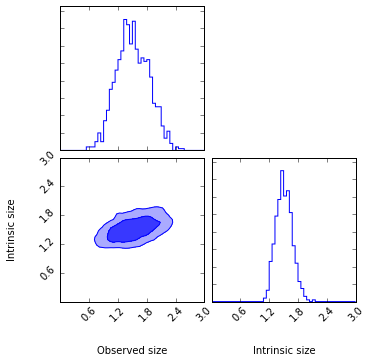

In [30]:
to_plot = np.array([observed['size'],intrinsic['size']]).transpose()
fig = triangle.corner(to_plot,labels=['Observed size','Intrinsic size'],range=[(0.0,3.0),(0.0,3.0)],color='Blue',plot_datapoints=False, fill_contours=True,
                levels=[0.68, 0.95], bins=50, smooth=1.)

## Probabilistic Graphical Models

We can draw a diagram representing the above combination of probability distributions, that:

* Shows the dependencies between variables
* Gives you a recipe for generating *mock data*


[We can also do this in python, using the `daft` package.](FirstPGM.ipynb):

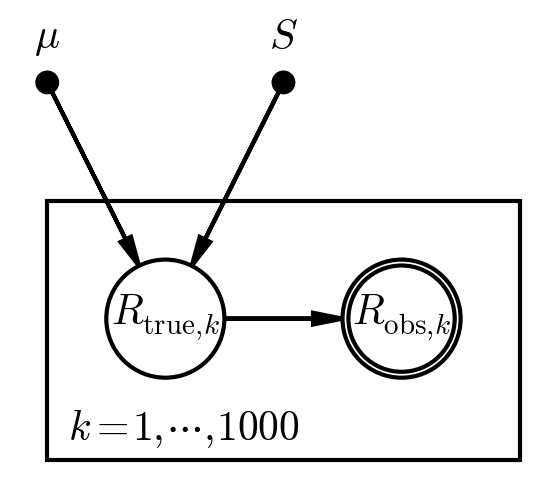

In [58]:
from IPython.display import Image
Image(filename="samplingdistributions.png")

### Q: Where should $\sigma$ go?